# 训练模型

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# 数据集地址

base_dir = "../datasets/cats_vs_dogs/"
train_dir = os.path.join(base_dir, "train")
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

val_dir = os.path.join(base_dir, "valid")
val_cats_dir = os.path.join(val_dir, "cats")
val_dogs_dir = os.path.join(val_dir, "dogs")

# 参数
BATCH_SIZE = 100
IMG_SHAPE = 150
total_train = 23000
total_val = 2000

# 数据管道
image_gen_train = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary',
)

val_image_generator = ImageDataGenerator(rescale=1. / 255)
val_data_gen = val_image_generator.flow_from_directory(
    directory=val_dir,
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary',
)

# 创建模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),
                           activation='relu',
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 编译模型

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

# 训练模型
epochs = 10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))))

# 保存模型
model.save('../models/cats_and_dogs_small.h5')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
___________________________________

# 可视化中间激活

In [2]:
# 预处理单张图像
from tensorflow.keras.preprocessing import image

img_path = "../datasets/cats_vs_dogs/valid/cats/cat.7248.jpg"

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


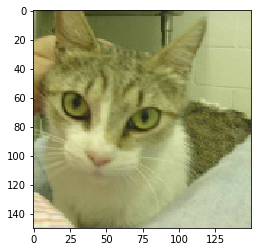

In [3]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [5]:
# 加载模型
from tensorflow.keras import models
from tensorflow.keras.models import load_model
model = load_model('../models/cats_and_dogs_small.h5')

In [6]:
# 提取模型每层输出

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [7]:
# 预测
activations = activation_model.predict(img_tensor)

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


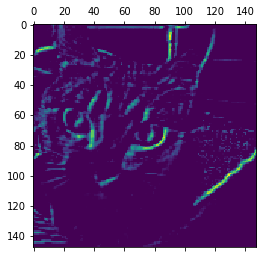

In [9]:
# 可视化输出特征图的 第四通道
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis');

> 该通道似乎是对角边缘检测器

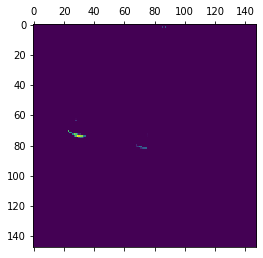

In [10]:
plt.matshow(first_layer_activation[0, :, :, 23], cmap='viridis')

> 该通道似乎是检测 眼睛

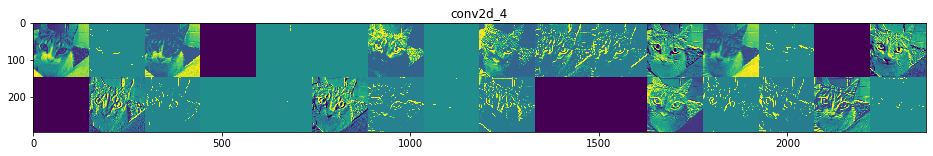

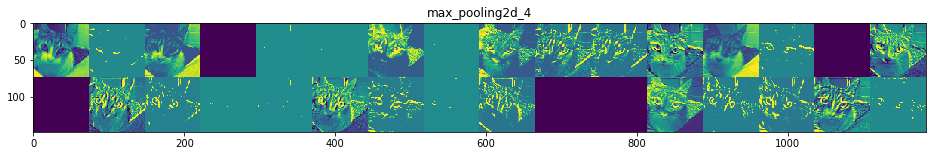

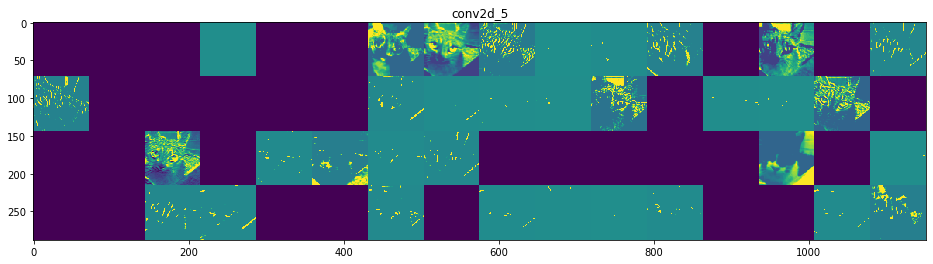

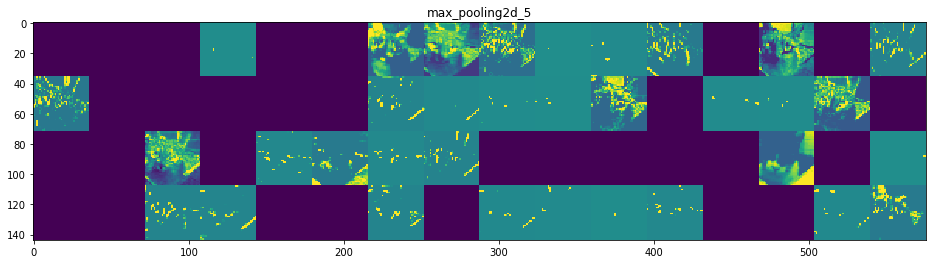

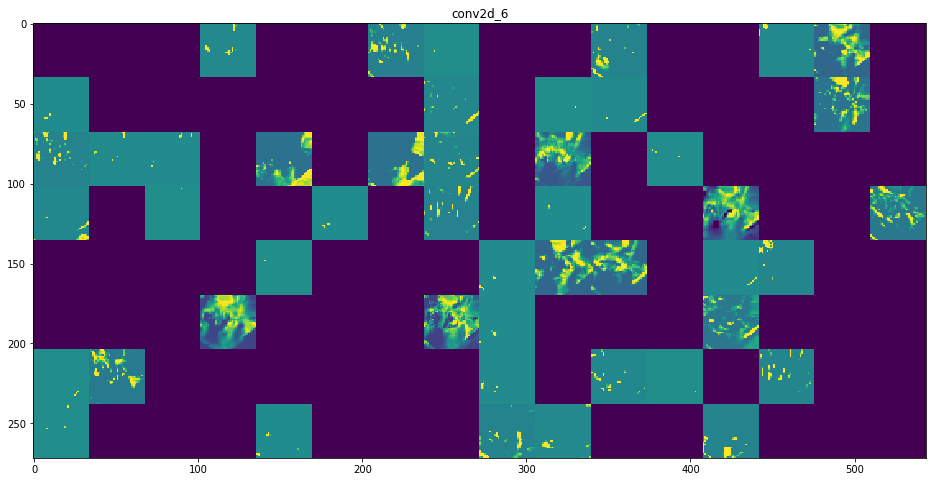

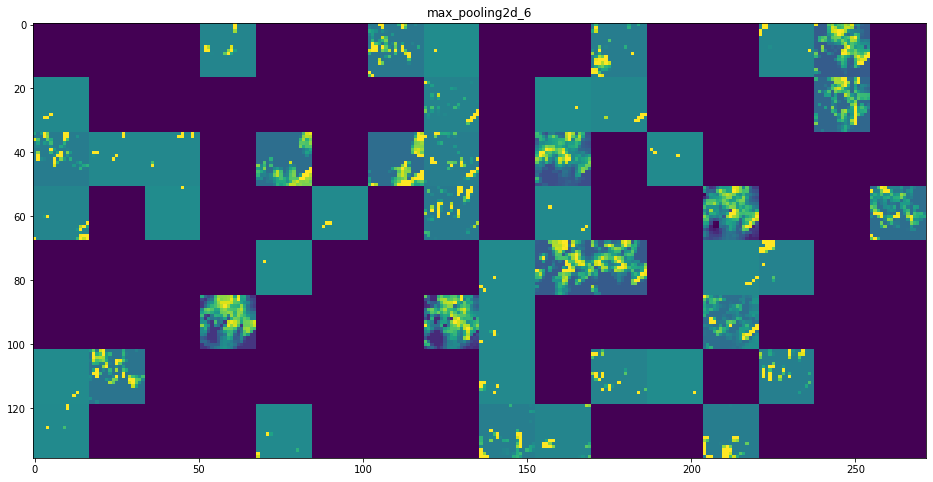

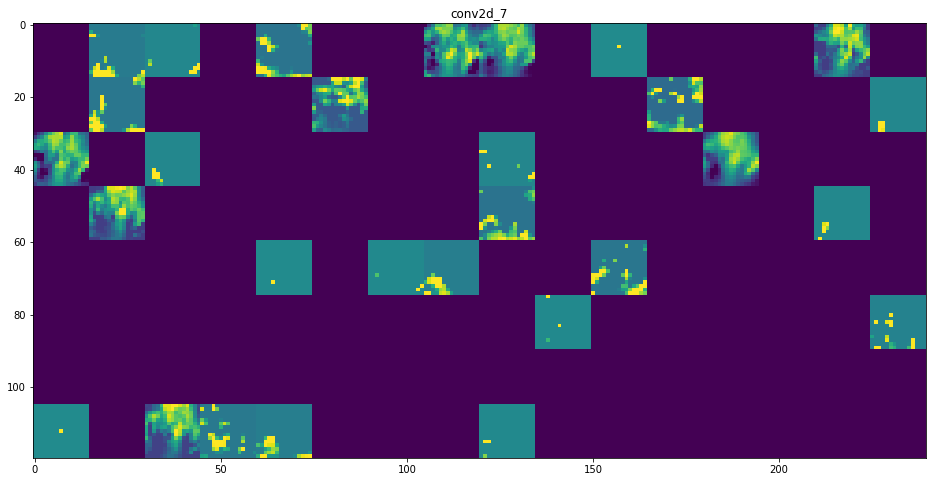

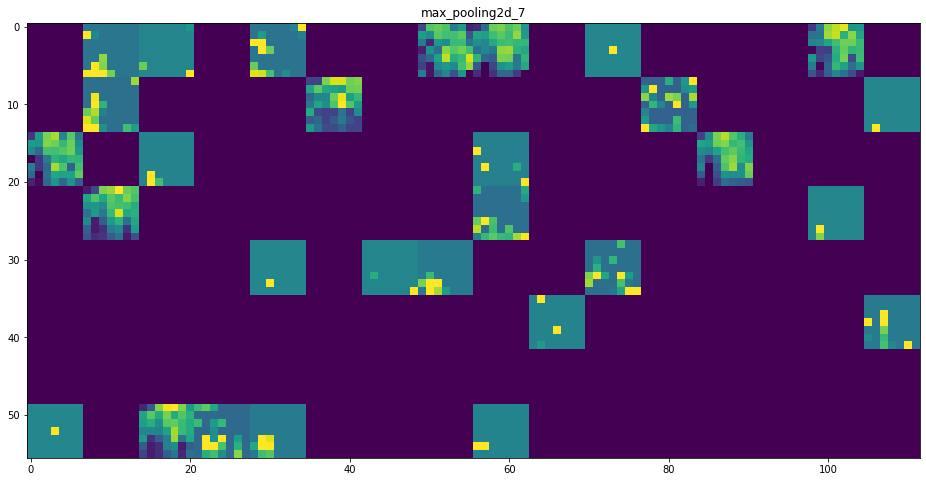

In [12]:
# 将每个中间激活层的所有通道可视化

layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)

img_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # 通道数量， 特征图的个数
    size = layer_activation.shape[1]  # 1,size,size,n_features

    n_cols = n_features // img_per_row
    display_grid = np.zeros((size * n_cols, img_per_row * size))

    for col in range(n_cols):
        for row in range(img_per_row):
            channel_img = layer_activation[0, :, :, col * img_per_row + row]
            channel_img -= channel_img.mean()
            channel_img /= channel_img.std()
            channel_img *= 64
            channel_img += 128
            channel_img = np.clip(channel_img, 0, 255).astype('uint8')
            display_grid[col * size:(col + 1) * size, row * size:(row + 1) *
                         size] = channel_img
    scale = 1. / size

    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))

    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

>-  第一层是各种边缘探测器的集合；这一阶段，激活几乎保留了原始图像中的所有信息
- 随着层数加深，激活变得越来越抽象，越来越难以直观地理解。开始表现更高层次的概念，如猫耳朵或猫眼睛。**层数加深，关于视觉内容的信息就越少，关于类别的信息就越多**
- 激活的稀疏度随着层数的加深而增大。越来越多的过滤器是空白。输入图像找不到这些过滤器所编码的模式

# 可视化过滤器

> 显示每个过滤器所响应的视觉模式，通过在输入空间中**进行梯度上升**来实现:
- 从空白输入图像开始,将梯度下降应用到卷积神经网络输入图像的值,其目的是让某个过滤器的响应最大化.得到的输入图像是选定过滤器具有最大响应的图像

# 可视化类激活的热力图
类激活图(CAM,class activation map)

In [17]:
# from tensorflow.keras.applications.vgg16 import VGG16
# model = VGG16(weights='imagenet')

# 模型下载不成功

In [24]:
from tensorflow.keras import layers, models


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    """
        
    # Determine proper input shape
    input_shape = (224, 224, 3)
    img_input = layers.Input(shape=input_shape)
    
        
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)


    # Create model.
    model = models.Model(img_input, x, name='vgg16')

    # Load weights.
    weights_path = "../../.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
    model.load_weights(weights_path)

    return model


model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [28]:
img_path = '../datasets/elephants.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [30]:
preds = model.predict(x)
print("Predicted: ", decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 1s 23us/step
Predicted:  [('n02504458', 'African_elephant', 0.63333625), ('n01871265', 'tusker', 0.279683), ('n02504013', 'Indian_elephant', 0.08687375)]


In [31]:
np.argmax(preds)

386

In [39]:
# 展示图片中哪部分最像非洲象，Grad-CAM 算法
from tensorflow.keras import backend as K

african_elephant_output = model.output[:, 386]  # 预测向量中的非洲象元素
last_conv_layer = model.get_layer('block5_conv3')

# 非洲象类别相对于 blcok5_conv3 输出特征图的梯度
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 形状是 （512，）的张量，每个元素是特定特征图通道的梯度平均大小
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 访问刚刚定义的量，对于给定的样本图像，pooled_grads 和 block5_conv3 的输出特征图
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 对于样本图像，这两个量都是 Numpy 数组
pooled_grads_value, conv_layer_output_value = iterate([x])

# 将特征图数组的每个通道乘以 这个通道 对 大象 类别的重要程度
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 得到的特征图的逐通道平均值即为激活热力图    
heatmap = np.mean(conv_layer_output_value, axis=-1)    

TypeError: 'GradientTape' object is not subscriptable